In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Image Count per Class: {'MildDemented': 8000, 'ModerateDemented': 8000, 'NonDemented': 10240, 'VeryMildDemented': 108}


c:\Users\neel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


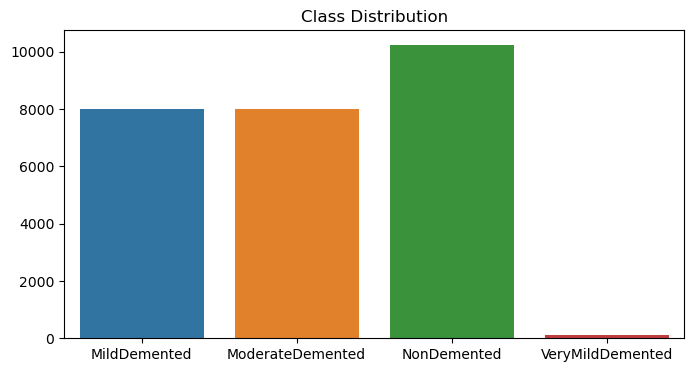

In [15]:

data_dir = r'C:\Users\neel\OneDrive\Desktop\dl_project\data_split\train'
classes = os.listdir(data_dir)
print("Classes:", classes)

img_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}
print("Image Count per Class:", img_counts)

plt.figure(figsize=(8,4))
sns.barplot(x=list(img_counts.keys()), y=list(img_counts.values()))
plt.title("Class Distribution")
plt.show()

In [16]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [17]:
train_data = datasets.ImageFolder(root=r'C:\Users\neel\OneDrive\Desktop\dl_project\data_split\train', transform=transform)
test_data = datasets.ImageFolder(root=r'C:\Users\neel\OneDrive\Desktop\dl_project\data_split\test', transform=transform)

class_counts = [0] * len(classes)
for _, label in train_data:
    class_counts[label] += 1

class_weights = [1.0 / class_counts[label] for _, label in train_data]
sampler = WeightedRandomSampler(weights=class_weights, num_samples=len(class_weights), replacement=True)

train_loader = DataLoader(train_data, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [18]:
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*64*64, 1024)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, 4)  # 4 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.drop1(self.relu1(self.fc1(x)))
        x = self.drop2(self.relu2(self.fc2(x)))
        x = self.relu3(self.fc3(x))
        return self.fc4(x)

In [19]:
model = SimpleANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")


100%|██████████| 824/824 [10:26<00:00,  1.32it/s]


Epoch [1/5], Loss: 1.1521, Accuracy: 0.4620


100%|██████████| 824/824 [26:55<00:00,  1.96s/it]


Epoch [2/5], Loss: 1.0066, Accuracy: 0.5203


100%|██████████| 824/824 [39:34<00:00,  2.88s/it]   


Epoch [3/5], Loss: 0.9229, Accuracy: 0.5709


 35%|███▍      | 287/824 [14:19<24:59,  2.79s/it] 

In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))


Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.75      0.83      0.79      2000
ModerateDemented       0.96      0.86      0.91      2000
     NonDemented       0.85      0.86      0.85      2560
VeryMildDemented       0.00      0.00      0.00        28

        accuracy                           0.85      6588
       macro avg       0.64      0.64      0.64      6588
    weighted avg       0.85      0.85      0.85      6588



c:\Users\neel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\neel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\neel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


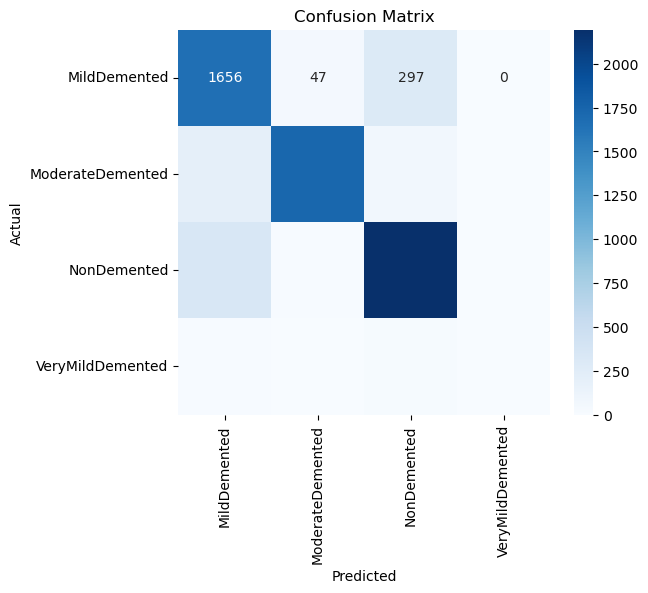

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()